In [1]:
%load_ext autoreload
%autoreload 2

import gsum as gm
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from stats_utils import *
from matter import *
import seaborn as sns
import time

%matplotlib inline

In [2]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.family'] = 'serif'
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, format='pdf')

# Analysis of Nuclear Matter Results (Refactored)

A much cleaner version of the other notebook. It can be easily extended.

First, import the data

In [3]:
df = pd.read_csv('../data/all_matter_data.csv')
# Convert differences to total prediction at each MBPT order
mbpt_orders = ['Kin', 'MBPT_HF', 'MBPT_2', 'MBPT_3', 'MBPT_4']
df[mbpt_orders] = df[mbpt_orders].apply(np.cumsum, axis=1)
# 'total' is now unnecessary. Remove it.
df.pop('total');

Now define all of the parameters of the analysis.

In [4]:
orders = np.array([0, 2, 3, 4])
# body = 'NN-only'
body = 'NN+3N'
Lambda = 450
fits = {450: [1, 7], 500: [4, 10]}
train1 = slice(None, None, 5)
valid1 = slice(2, None, 5)
# valid1 = np.array([i % 5 != 0 for i in range(len())])
[fit_n2lo, fit_n3lo] = fits[Lambda]

excluded = np.array([1])

savefigs = False

Lb = 600

breakdown_min = 300
breakdown_max = 1000
breakdown_num = 100
Lb_vals = np.linspace(breakdown_min, breakdown_max, breakdown_num)
Lb_logprior_vals = Lb_logprior(Lb_vals)

ls_min = 0.1
ls_max = 1.5
ls_num = 50
ls_vals = np.linspace(ls_min, ls_max, ls_num)
# ls_min = ls_max = ls_num = ls_vals = None

nugget = 1e-8

kernel1 = RBF(length_scale=1, length_scale_bounds=(5e-2, 4)) + \
    WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
# kernel1 = RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + \
#     WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
kernel1_theta = kernel1.theta
ref1 = 16

hyperparams = dict(
    center=0,
    disp=0,
    df=1,
    scale=1
)


mask_fit = np.isin(df['fit'], fits[Lambda]) | np.isnan(df['fit'])

mask1 = \
    (df['Body'] == body) & \
    mask_fit & \
    (df['Lambda'] == Lambda)


# df_fit = df[mask_fit]
df_n = df[mask1 & (df['x'] == 0)]
df_s = df[mask1 & (df['x'] == 0.5)]

kf_n = df_n[df_n['OrderEFT'] == 'LO']['kf'].values
kf_s = df_s[df_s['OrderEFT'] == 'LO']['kf'].values
density = df_n[df_n['OrderEFT'] == 'LO']['n'].values
kf_d = kf_n.copy()

# valid1 = np.arange(len(kf_n)) % 5 != 0

Kf_n = kf_n[:, None]
Kf_s = kf_s[:, None]
Kf_d = kf_d[:, None]

kf_n_dense = np.linspace(kf_n.min(), kf_n.max(), 100)
Kf_n_dense = kf_n_dense[:, None]

kf_s_dense = np.linspace(kf_s.min(), kf_s.max(), 100)
Kf_s_dense = kf_s_dense[:, None]

kf_d_dense = np.linspace(kf_d.min(), kf_d.max(), 100)
Kf_d_dense = kf_d_dense[:, None]

y1_n = np.array([df_n[df_n['OrderEFT'] == order]['MBPT_4'].values for order in df_n['OrderEFT'].unique()]).T
y1_s = np.array([df_s[df_s['OrderEFT'] == order]['MBPT_4'].values for order in df_s['OrderEFT'].unique()]).T
y1_d = y1_n - y1_s

These analysis objects will contain all the observable-specific info and know how to make various plots.
The plots will save with informative image names and avoid a cluttered namespace. As we start varying more parameters, we should make sure that each important variable is reflected in the figure names, so that we don't overwrite images.

In [5]:
analysis_n = MatterConvergenceAnalysis(
    X=Kf_n, y=y1_n, orders=orders, train=train1, valid=valid1, ref=ref1, ratio='kf', density=density,
    kernel=kernel1, system='neutron', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
    body=body, savefigs=savefigs, excluded=excluded, **hyperparams
)
analysis_s = MatterConvergenceAnalysis(
    X=Kf_s, y=y1_s, orders=orders, train=train1, valid=valid1, ref=ref1, ratio='kf', density=density,
    kernel=kernel1, system='symmetric', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
    body=body, savefigs=savefigs, excluded=excluded, **hyperparams
)
analysis_d = MatterConvergenceAnalysis(
    X=Kf_d, y=y1_d, orders=orders, train=train1, valid=valid1, ref=ref1, ratio='kf', density=density,
    kernel=kernel1, system='difference', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
    body=body, savefigs=savefigs, excluded=excluded, **hyperparams
)

Can take a while if a large breakdown/ls grid is used

In [6]:
t_start = time.time()
analysis_n.setup_posteriors(
    breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
    ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
    max_idx=[2, 3], logprior=None
)
analysis_s.setup_posteriors(
    breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
    ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
    max_idx=[2, 3], logprior=None
)
analysis_d.setup_posteriors(
    breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
    ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
    max_idx=[2, 3], logprior=None
);
print(time.time() - t_start)

24.95354914665222


Create a DataFrame that holds the $\Lambda_b$ pdf for all observables put together. Assume they are independent, so they multiply. Also, we assumed a constant prior above, so we don't need to worry about accidentally overcounting it.

In [7]:
df_Lb_pdf_all = analysis_n.df_breakdown.copy()
df_Lb_pdf_all['pdf'] = analysis_n.df_breakdown['pdf'] * analysis_s.df_breakdown['pdf'] * analysis_d.df_breakdown['pdf']
df_Lb_pdf_all['system'] = 'All'

In [8]:
def dict_to_str(d):
    s = ''
    for key, value in d.items():
        s += f'{key}-{value}_'
    s = s.replace('.', 'p')
    return s[:-1]

Create the plot of all their pdfs

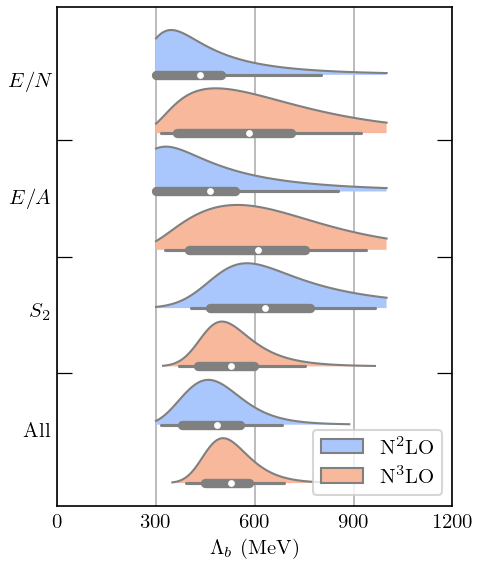

In [9]:
fig, ax = plt.subplots(figsize=(3.4, 4.4))
df_Lb_pdf = pd.concat([analysis_n.df_breakdown, analysis_s.df_breakdown, analysis_d.df_breakdown, df_Lb_pdf_all])
ax = pdfplot(
    x=r'$\Lambda_b$ (MeV)', y='system', pdf='pdf', data=df_Lb_pdf, hue='Order',
    order=[r'$E/N$', r'$E/A$', r'$S_2$', 'All'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1,
        palette="coolwarm", saturation=1., ax=ax, margin=0.3,
)
ax.set_xlim(0, 1200)
ax.set_xticks([0, 300, 600, 900, 1200])
ax.grid(axis='x')
ax.set_axisbelow(True)
if savefigs:
    fig.savefig(
        analysis_n.figure_name(
            'Lb_pdfs_', breakdown=(breakdown_min, breakdown_max, breakdown_num), include_system=False,
            ls=(ls_min, ls_max, ls_num),
        )
    )

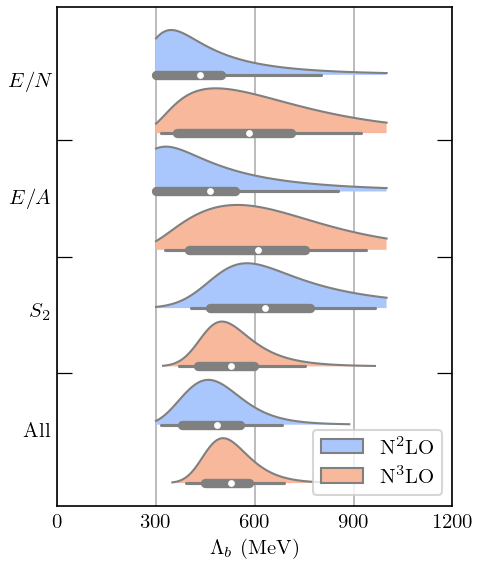

In [10]:
fig, ax = plt.subplots(figsize=(3.4, 4.4))
df_Lb_pdf = pd.concat([analysis_n.df_breakdown, analysis_s.df_breakdown, analysis_d.df_breakdown, df_Lb_pdf_all])
ax = pdfplot(
    x=r'$\Lambda_b$ (MeV)', y='system', pdf='pdf', data=df_Lb_pdf, hue='Order',
    order=[r'$E/N$', r'$E/A$', r'$S_2$', 'All'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1,
        palette="coolwarm", saturation=1., ax=ax, margin=0.3,
)
ax.set_xlim(0, 1200)
ax.set_xticks([0, 300, 600, 900, 1200])
ax.grid(axis='x')
ax.set_axisbelow(True)
if savefigs:
    fig.savefig(
        analysis_n.figure_name(
            'Lb_pdfs_', breakdown=(breakdown_min, breakdown_max, breakdown_num), include_system=False,
            ls=(ls_min, ls_max, ls_num),
        )
    )

Now one for the marginal length scale pdfs. A common length scale for all observables probably isn't necessary, so don't compute an "All" pdf.

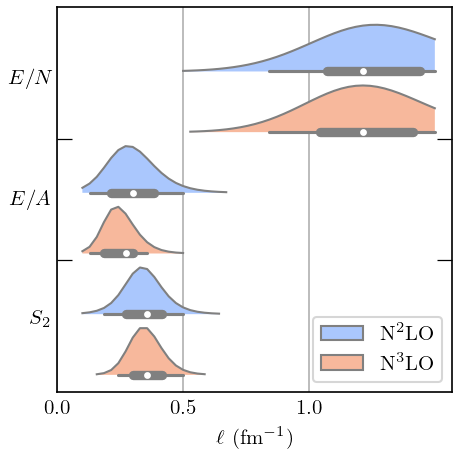

In [11]:
df_ls_pdf = pd.concat([analysis_n.df_ls, analysis_s.df_ls, analysis_d.df_ls])
ax = pdfplot(
    x=r'$\ell$ (fm$^{-1}$)', y='system', pdf='pdf', data=df_ls_pdf, hue='Order',
    order=[r'$E/N$', r'$E/A$', r'$S_2$'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1.,
        palette="coolwarm", saturation=1., ax=None, margin=0.3,
)
ax.set_xticks([0, 0.5, 1.]);
ax.grid(axis='x');
ax.set_axisbelow(True)
if savefigs:
    fig.savefig(
        analysis_n.figure_name(
            'ls_pdfs_', breakdown=(breakdown_min, breakdown_max, breakdown_num), include_system=False,
            ls=(ls_min, ls_max, ls_num),
        )
    )

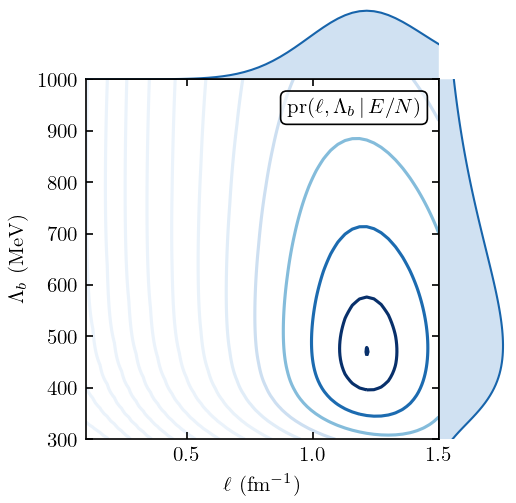

In [12]:
fig = analysis_n.plot_joint_breakdown_ls(max_idx=3)

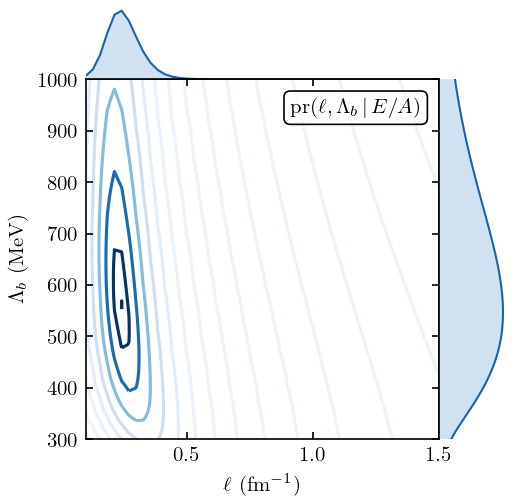

In [13]:
fig = analysis_s.plot_joint_breakdown_ls(max_idx=3)

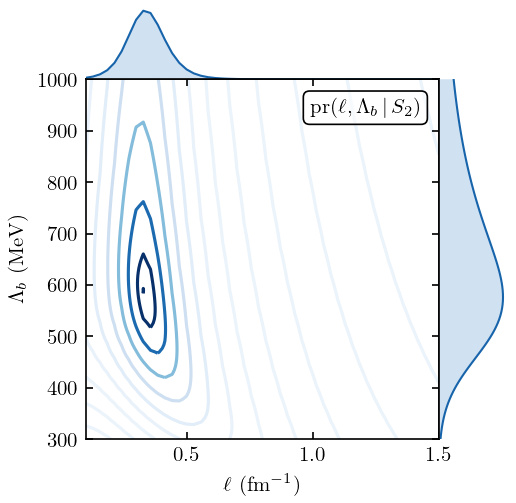

In [14]:
fig = analysis_d.plot_joint_breakdown_ls(max_idx=2)

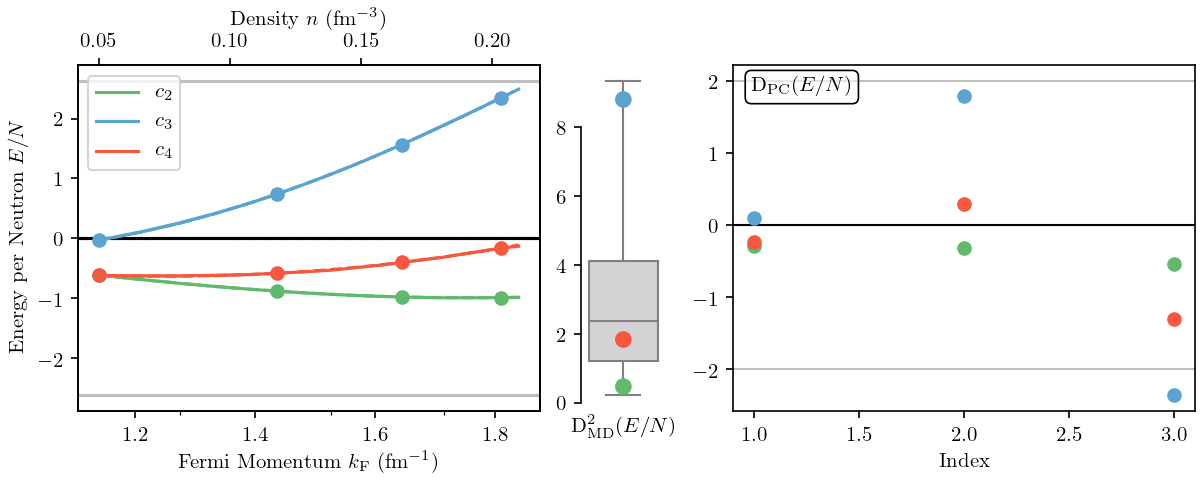

In [15]:
fig = analysis_n.plot_coeff_diagnostics(breakdown=Lb)

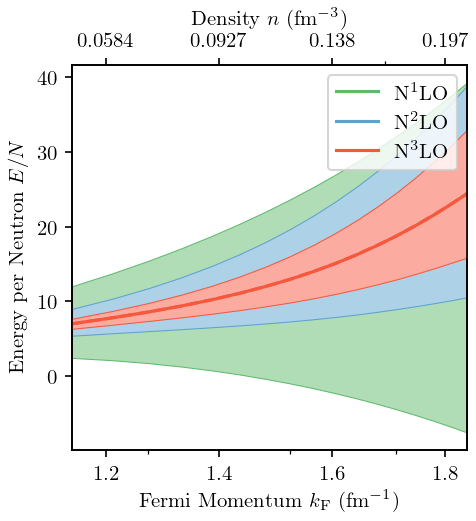

In [16]:
fig = analysis_n.plot_observables(breakdown=Lb, show_process=True)

Using breakdown = 469.6969696969697 MeV


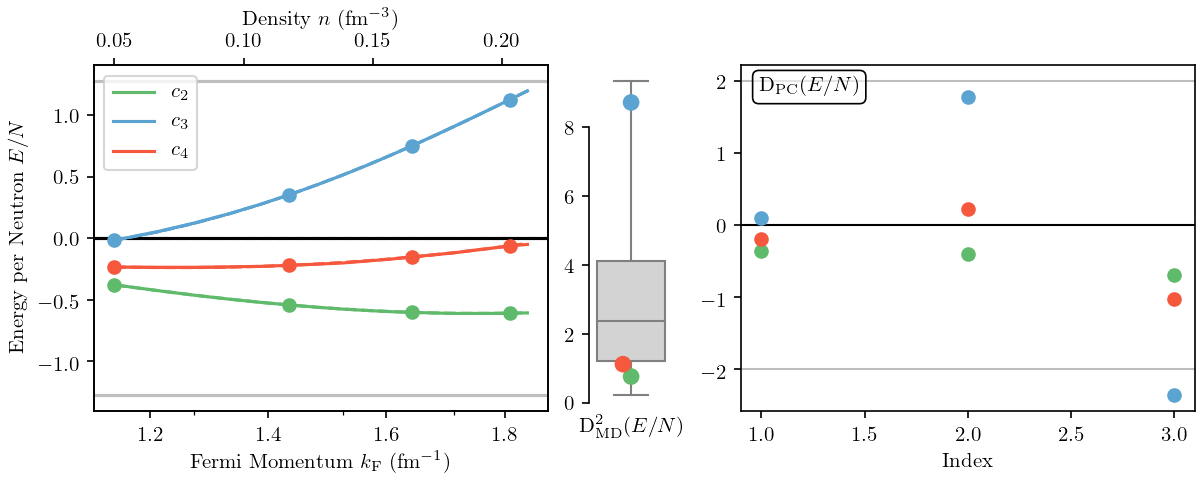

In [17]:
fig = analysis_n.plot_coeff_diagnostics(breakdown=None)

Using breakdown = 469.6969696969697 MeV


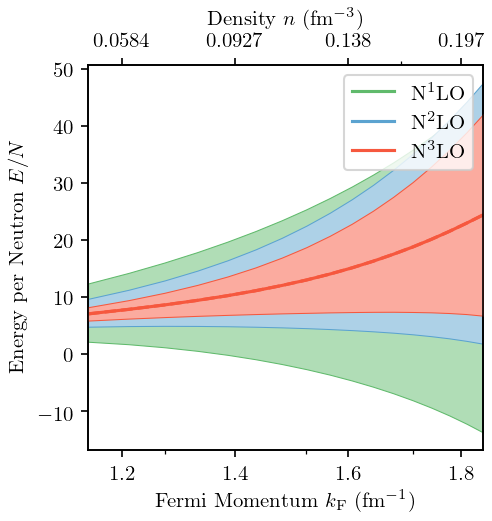

In [18]:
fig = analysis_n.plot_observables(breakdown=None, show_process=True)

There's clearly some noise below, we should include it in the kernel. Discuss with Christian about the precision of his calculations.

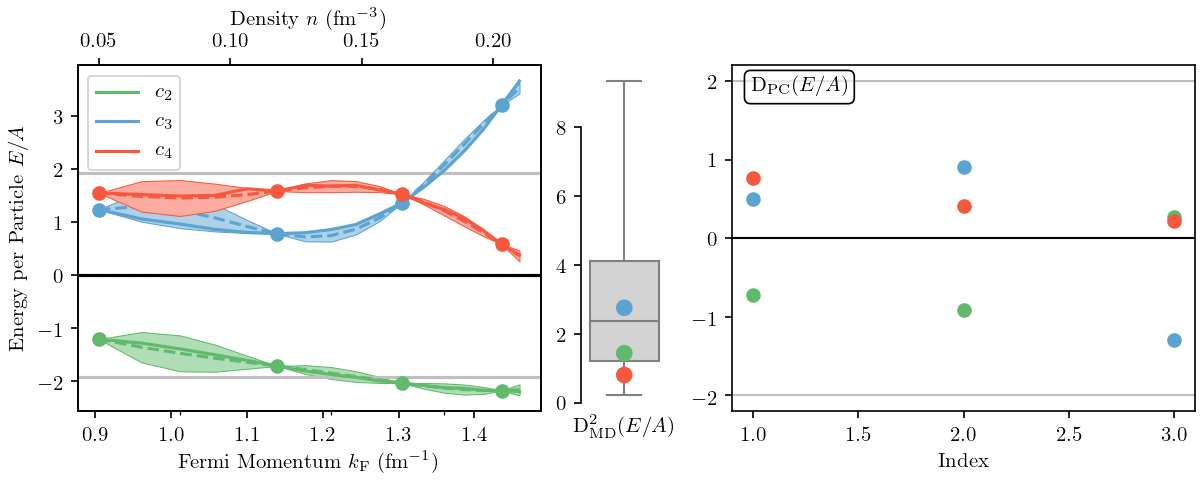

In [19]:
fig = analysis_s.plot_coeff_diagnostics(breakdown=Lb)

Using breakdown = 561.6161616161617 MeV


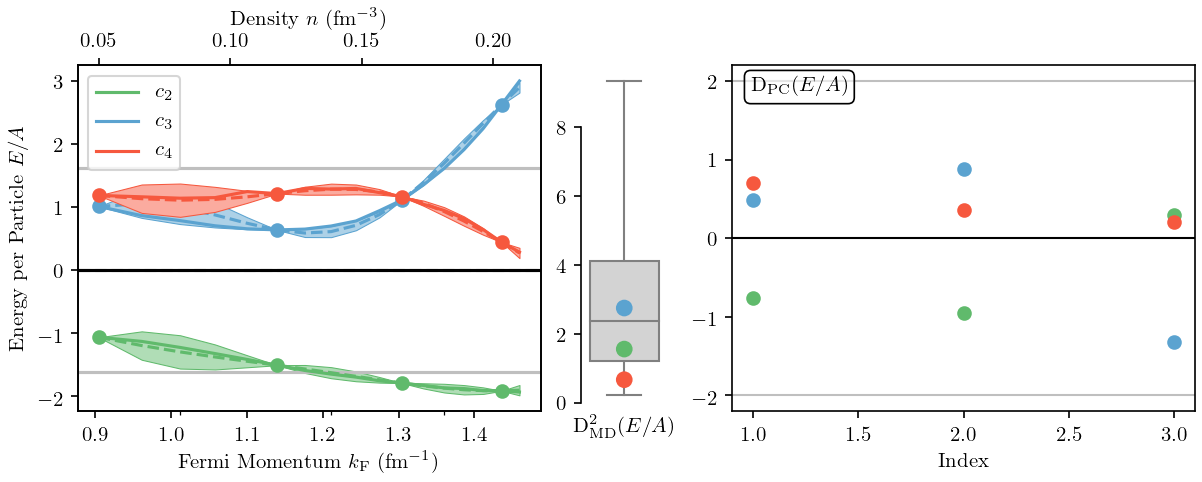

In [20]:
fig = analysis_s.plot_coeff_diagnostics(breakdown=None)

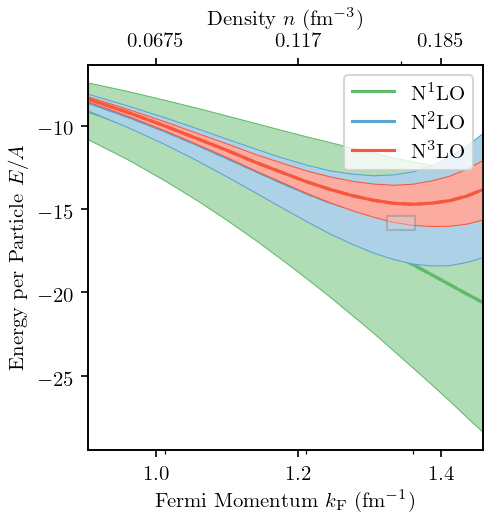

In [21]:
fig = analysis_s.plot_observables(breakdown=Lb, show_process=True)

Using breakdown = 561.6161616161617 MeV


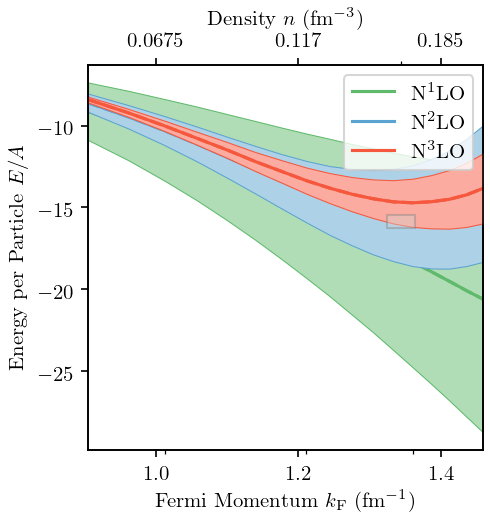

In [22]:
fig = analysis_s.plot_observables(breakdown=None, show_process=True)

In [23]:
np.squeeze(np.argwhere(np.arange(5) == 3))

array(3)

In [24]:
kf_s_dense = np.linspace(kf_s.min(), kf_s.max(), 200)
Kf_s_dense = kf_s_dense[:, None]
n_samples = 3000
# The points to fit the GP to (but hyperparameter training is still at "train")
sat_conditioned = slice(None, None, 2)

RBF(length_scale=0.235) + WhiteKernel(noise_level=1e-08)
RBF(length_scale=0.235) + WhiteKernel(noise_level=1e-08)


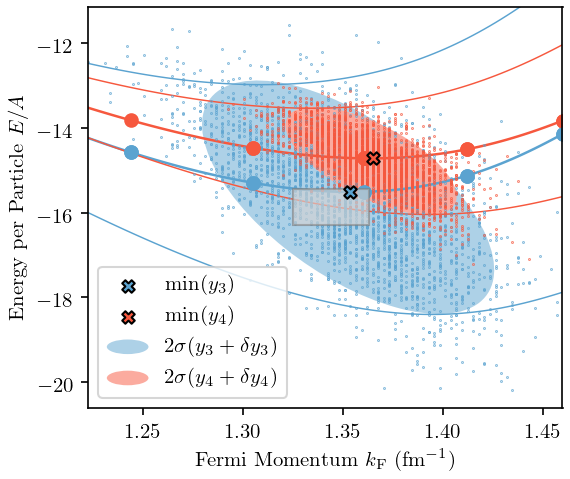

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.4))

np.random.seed(1)
_, ellipse3 = analysis_s.plot_saturation(breakdown=Lb, order=3, nugget=1e-7, X=Kf_s_dense, cond=sat_conditioned, n_samples=n_samples)
_, ellipse4 = analysis_s.plot_saturation(breakdown=Lb, order=4, nugget=1e-7, X=Kf_s_dense, cond=sat_conditioned, n_samples=n_samples)

ax = plt.gca()
ax.plot(kf_s[sat_conditioned][4:], y1_s[sat_conditioned][4:, -1], ls='', marker='o', c=analysis_s.colors[-1])
ax.plot(kf_s[sat_conditioned][4:], y1_s[sat_conditioned][4:, -2], ls='', marker='o', c=analysis_s.colors[-2])
ax.margins(x=0)

handles, labels = ax.get_legend_handles_labels()
handles.append(ellipse3)
handles.append(ellipse4)
labels.append(r'$2\sigma(y_3+\delta y_3)$')
labels.append(r'$2\sigma(y_4+\delta y_4)$')
ax.legend(handles, labels)
fig.tight_layout()
# fig.savefig()


RBF(length_scale=0.235) + WhiteKernel(noise_level=1e-08)
RBF(length_scale=0.235) + WhiteKernel(noise_level=1e-08)


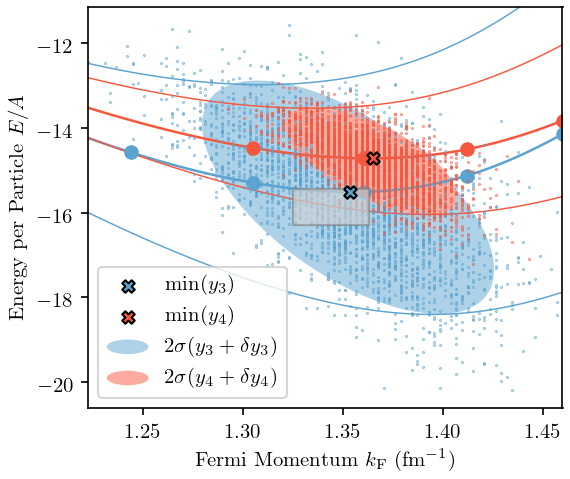

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.4))
np.random.seed(1)
analysis_s.plot_multi_saturation(
    breakdown=Lb, orders=[3,4], nugget=1e-7, X=Kf_s_dense,
    cond=sat_conditioned, n_samples=n_samples, ax=ax, savefig=True
);

RBF(length_scale=0.235) + WhiteKernel(noise_level=1e-08)
RBF(length_scale=0.235) + WhiteKernel(noise_level=1e-08)


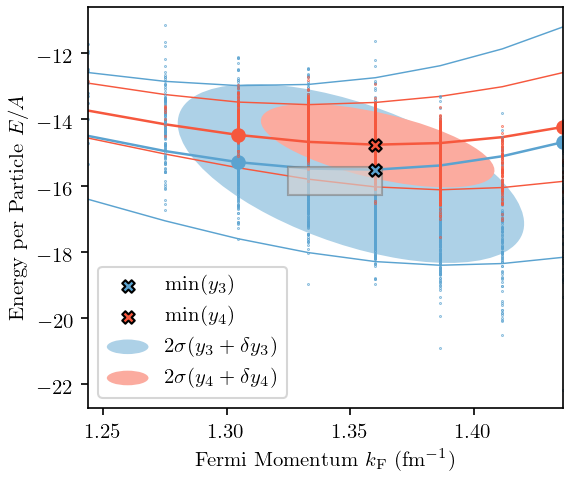

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.4))
np.random.seed(1)
analysis_s.plot_multi_saturation(
    breakdown=Lb, orders=[3,4], nugget=1e-7, X=Kf_s,
    cond=train1,
    n_samples=n_samples, ax=ax, savefig=False
);

RBF(length_scale=0.325) + WhiteKernel(noise_level=1e-08)
RBF(length_scale=0.325) + WhiteKernel(noise_level=1e-08)


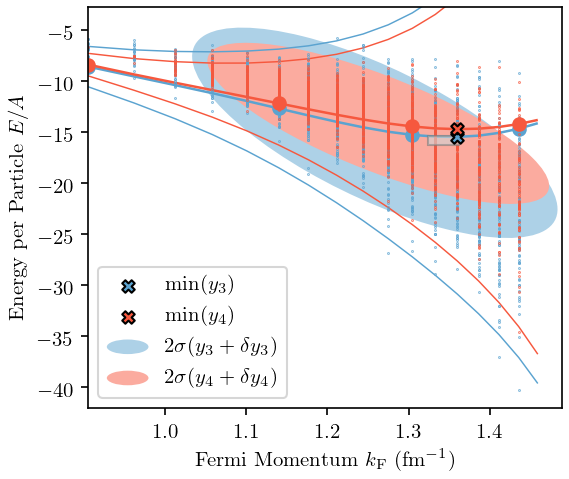

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.4))
np.random.seed(1)
analysis_s.plot_multi_saturation(
    breakdown=320., orders=[3,4], nugget=1e-5, X=Kf_s,
    cond=train1,
    n_samples=n_samples, ax=ax, savefig=False
);

Using breakdown = 561.6161616161617 MeV
RBF(length_scale=0.24) + WhiteKernel(noise_level=1e-08)
RBF(length_scale=0.24) + WhiteKernel(noise_level=1e-08)


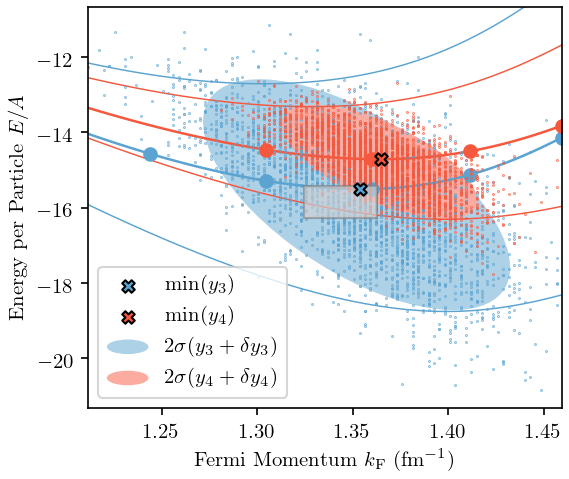

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.4))
np.random.seed(1)
analysis_s.plot_multi_saturation(
    orders=[3,4], nugget=1e-5, X=Kf_s_dense,
    cond=sat_conditioned, n_samples=n_samples, ax=ax, savefig=True
);

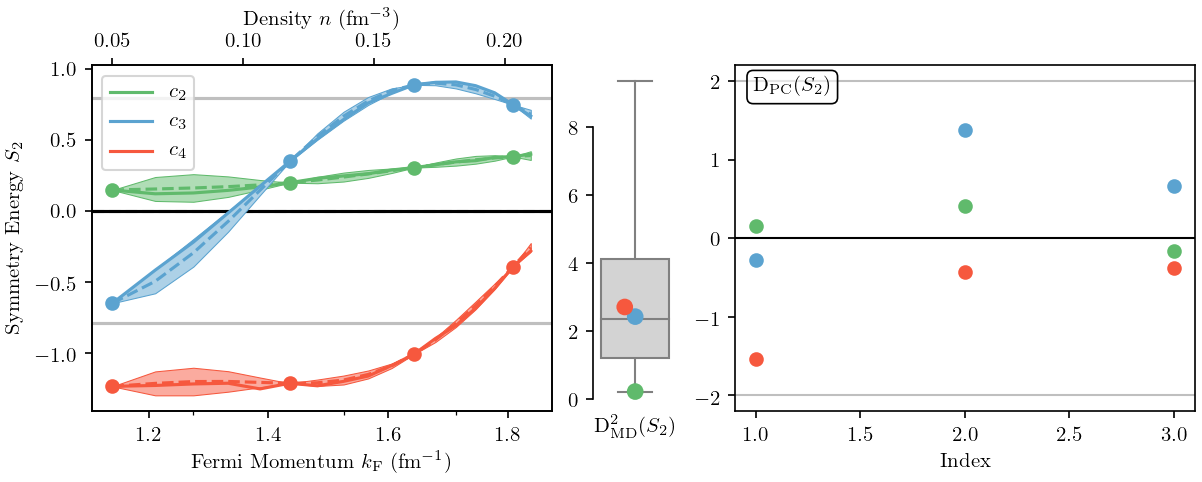

In [28]:
fig = analysis_d.plot_coeff_diagnostics(breakdown=Lb)

Using breakdown = 497.979797979798 MeV


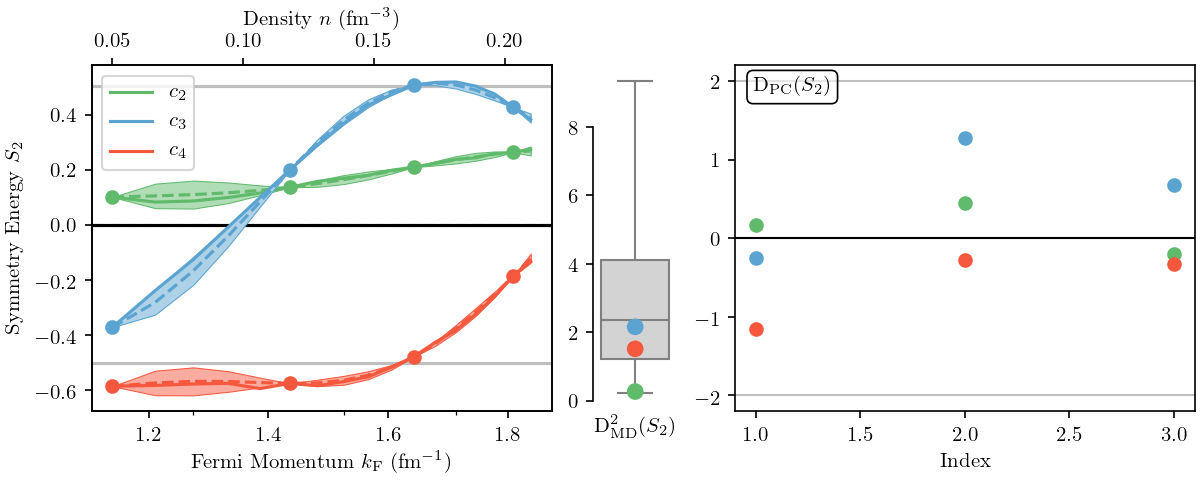

In [29]:
fig = analysis_d.plot_coeff_diagnostics(breakdown=None)

In [30]:
# fig = analysis_d.plot_observables(breakdown=Lb, show_process=True)

In [31]:
# fig = analysis_d.plot_observables(breakdown=None, show_process=True)

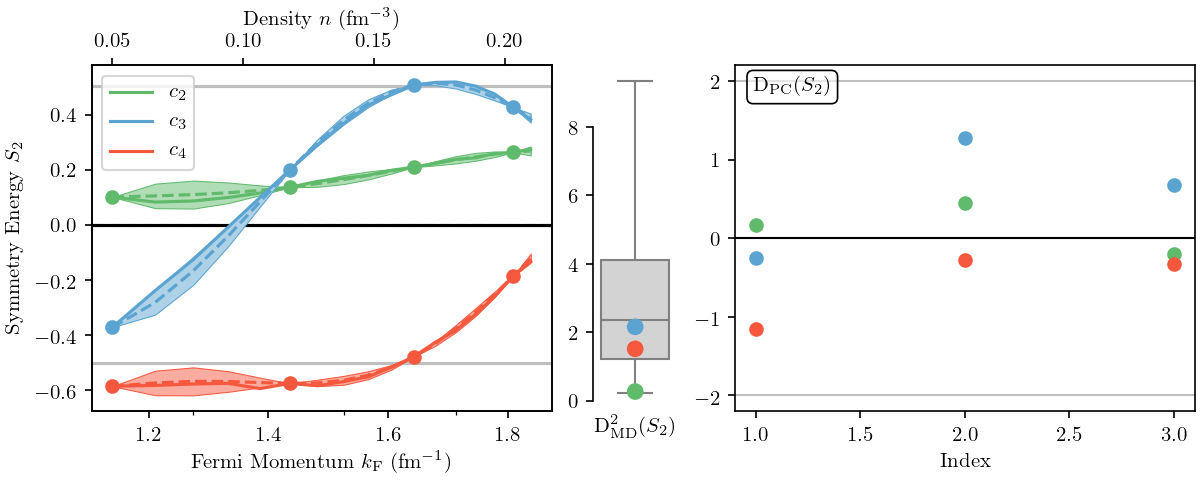

In [32]:
fig

In [33]:
# fig.savefig('test', metadata=dict(Keywords='??'))